In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import ndimage
import importlib

In [2]:
from multi_loc import covariance, assimilate, utilities

In [3]:
%matplotlib inline
def imshow(X, title=None, vmin=None, vmax=None, cmap=None, dpi=None):
    plt.figure(dpi=dpi)
    im = plt.imshow(X, vmin=vmin, vmax=vmax, cmap=cmap)
    plt.colorbar(im)
    plt.title(title)

In [4]:
Nz = 2**9
rho0_l = 0.2
rho0_s = 0.002
coarse = 8
R_var = 1

dz = 1/Nz
z = np.arange(Nz)

Hz = np.eye(Nz)[::4]
Ny = Hz.shape[0]
y = Hz @ z

Nx = Nz // coarse
dx = dz * coarse
Sz2x = np.eye(Nz)[::coarse]
Sx2z = utilities.lin_interp_matrix(Nz, coarse)

Hx = Hz @ Sx2z
x = Sz2x @ z

In [5]:
a_l = 0.6
Pz = covariance.two_scale_circulant(Nz, dz, rho0_l, rho0_s, a_l, covariance.fft_sqd_exp_1d)

# l_max = 0.9
# l_min = 0.2
# var = 8 * Nz
# zz = np.arange(Nz) - (Nz - 1)/2
# std_l = 1 - np.exp(-(zz)**2/(2 * var))
# std_l = (std_l - std_l.min())/(std_l.max() - std_l.min())
# std_l = std_l * (l_max - l_min) + l_min
# std_l = np.sqrt(std_l)
# Pz = covariance.two_scale_hetero(Nz, dz, rho0_l, rho0_s, covariance.fft_sqd_exp_1d, std_l)

In [6]:
R = R_var * np.eye(Ny)

Lam_z, Qz = np.linalg.eigh(Pz)
Lam_z = Lam_z[::-1]
Qz = Qz[:, ::-1]

Px = Pz[::coarse, ::coarse]
Lam_x, Qx = np.linalg.eigh(Px)
Lam_x = Lam_x[::-1]
Qx = Qx[:, ::-1]

trans_mats_true = assimilate.transformation_matrices(
    Hz, P=Pz,
    R=R, return_Ts=True)
for key, val in trans_mats_true.items():
    exec(key + 'z=val')
    
trans_mats_true = assimilate.transformation_matrices(
    Hx, P=Px,
    R=R, return_Ts=True)
for key, val in trans_mats_true.items():
    exec(key + 'x=val')

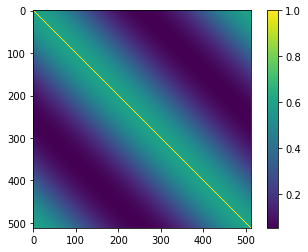

In [7]:
imshow(Pz)

In [8]:
Nez = 40
mu_z = np.random.multivariate_normal(np.zeros(Nz), Pz)
Zens = assimilate.generate_ensemble(Nez, mu_z, P_sqrtz)

In [9]:
Zobs = Hz @ mu_z
Zobs = Zobs[:, None] + np.random.multivariate_normal(np.zeros(Ny), R, Nez).T

In [10]:
def KF(Z, Zobs, Pz, H, R):
    K = Pz @ H.T @ np.linalg.pinv(H @ Pz @ H.T + R)
    Za = Z + K @ (Zobs - H @ Z)
    return Za

# Using actual Pz

$\mathbf{P} = \mathbf{P}_z$

$\mathbf{P}$ is the background error covariance used to calculate the Kalman gain.

$\mathbf{P}_z$ is the true background error covariance.  

In [11]:
Za_Pz = KF(Zens, Zobs, Pz, Hz, R)
mu_Pz = np.mean(Za_Pz, axis=1)
rmse_Pz = np.sqrt(((mu_z - mu_Pz)**2).mean())
print('Pz rmse: ', rmse_Pz)

Pz rmse:  0.0899665313972814


# Using actual Qz

$\mathbf{P} = \mathbf{Q}_z \text{diag}(\mathbf{Q}_z^T \mathbf{P}_{z; sam} \mathbf{Q}_z) \mathbf{Q}_z^T$

$\mathbf{P}_{z; sam}$ is the sample error covariance for $Z$.

$\mathbf{Q}_z \mathbf{\Lambda}_z \mathbf{Q}_z^T = \mathbf{P}_z$

In [12]:
Pz_sam = np.cov(Zens)
Pz_Qz = (Qz
         @ np.diag(np.diag(
             Qz.T @ Pz_sam @ Qz))
         @ Qz.T)
Za_Qz = KF(Zens, Zobs, Pz_Qz, Hz, R)
mu_Qz = np.mean(Za_Qz, axis=1)
rmse_Qz = np.sqrt(((mu_z - mu_Qz)**2).mean())
print('Qz rmse: ', rmse_Qz)

Qz rmse:  0.09095508329199992


# Using no localization

$\mathbf{P} = \mathbf{P}_{z; sam}$

In [13]:
Za_sam = KF(Zens, Zobs, Pz_sam, Hz, R)
mu_sam = np.mean(Za_sam, axis=1)
rmse_sam = np.sqrt(((mu_z - mu_sam)**2).mean())
print('sam rmse: ', rmse_sam)

sam rmse:  0.10634214832652958


# Using tuned standard localization

$\mathbf{P} = \mathbf{L} \circ \mathbf{P}_{z; sam}$

$\mathbf{L}$ is a tuned localization matrix.

In [14]:
def assimilate_stdrd(Zens, Zobs, Hz, R, Pz_sam, rho0_loc_s):
    [L_s] = covariance.generate_circulant(
        Nz, dz, rho0_loc_s,
        covariance.fft_sqd_exp_1d,
        return_eig=False, return_Corr=True)
    Pz_loc = L_s * Pz_sam
    Za = KF(Zens, Zobs, Pz_loc, Hz, R)
    return Za

In [15]:
loc_array_stdrd = np.linspace(0.00001, 0.3, 500)
rmse_stdrd = loc_array_stdrd * np.nan
for count, a_rho0 in enumerate(loc_array_stdrd):
    aZa = assimilate_stdrd(Zens, Zobs, Hz, R, Pz_sam, a_rho0)
    a_mu_z = np.mean(aZa, axis=1)
    rmse_stdrd[count] = np.sqrt(((a_mu_z - mu_z)**2).mean())

Standard loc RMSE:  0.09649385664874714


Text(0.5, 1.0, 'Comparison of different methods')

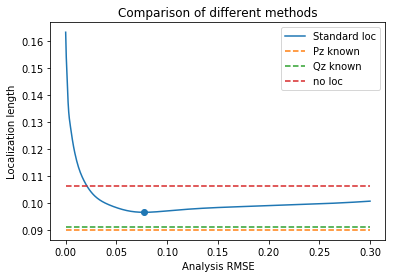

In [16]:
arg_min = np.argmin(rmse_stdrd)
rmse_stdrd_min = rmse_stdrd[arg_min]
opt_stdrd = loc_array_stdrd[arg_min]
print('Standard loc RMSE: ', rmse_stdrd_min)
plt.figure()
plt.plot(loc_array_stdrd, rmse_stdrd)
plt.plot(loc_array_stdrd,
         np.ones_like(loc_array_stdrd) * rmse_Pz, '--')
plt.plot(loc_array_stdrd,
         np.ones_like(loc_array_stdrd) * rmse_Qz, '--')
plt.plot(loc_array_stdrd,
         np.ones_like(loc_array_stdrd) * rmse_sam, '--')
plt.scatter(opt_stdrd, rmse_stdrd_min)
plt.xlabel('Analysis RMSE')
plt.ylabel('Localization length')
plt.legend(['Standard loc',
            'Pz known',
            'Qz known',
            'no loc'])
plt.title('Comparison of different methods')

# Using perfect initial directions (no secondary localization)

$\mathbf{P} = \mathbf{Q}_l \text{diag}(\mathbf{Q}_l^T \mathbf{P}_{z; sam} \mathbf{Q}_l) \mathbf{Q}_l^T$

$\mathbf{Q}_l = \mathbf{Q}_z[:, :N_l]$ where $N_l$ is the number of directions kept.

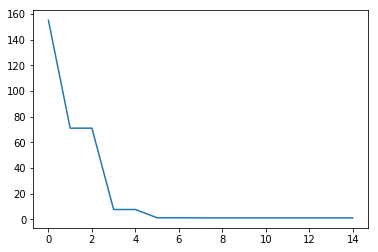

In [17]:
plt.figure()
plt.plot(Lam_z[:15])

In [18]:
sig_num = 5
Qzl = Qz[:, :sig_num]
Pz_Qzl = (Qzl
         @ np.diag(np.diag(
             Qzl.T @ Pz_sam @ Qzl))
         @ Qzl.T)
Za_Qzl = KF(Zens, Zobs, Pz_Qzl, Hz, R)
mu_Qzl = np.mean(Za_Qzl, axis=1)
rmse_Qzl = np.sqrt(((mu_z - mu_Qzl)**2).mean())
print('Qzl rmse: ', rmse_Qz)

Qzl rmse:  0.09095508329199992


# Perfect eig localization (tuned seconday loc)

$\mathbf{P}_s = \mathbf{L} \circ (\mathbf{P}_{z; sam} - \mathbf{P}_l)$

$\mathbf{P} = \mathbf{P}_l + \mathbf{P}_s$

In [19]:
def assimilate_eig(Zens, Zobs, Hz, R, Pz_Qzl, Pz_orth, rho0_loc_s):
    [L_s] = covariance.generate_circulant(
        Nz, dz, rho0_loc_s,
        covariance.fft_sqd_exp_1d,
        return_eig=False, return_Corr=True)
    Pz_loc = Pz_Qzl + L_s * Pz_orth
    Za = KF(Zens, Zobs, Pz_loc, Hz, R)
    return Za

In [20]:
Pz_orth = Pz_sam - Pz_Qzl
rmse_eig = rmse_stdrd * np.nan
for count, a_rho0 in enumerate(loc_array_stdrd):
    aZa = assimilate_eig(Zens, Zobs, Hz, R, Pz_Qzl, Pz_orth, a_rho0)
    a_mu_z = np.mean(aZa, axis=1)
    rmse_eig[count] = np.sqrt(((a_mu_z - mu_z)**2).mean())

Eigenvalue loc RMSE:  0.09017216927953199


(0.0899665313972814, 0.10634214832652958)

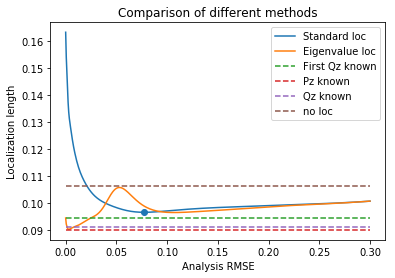

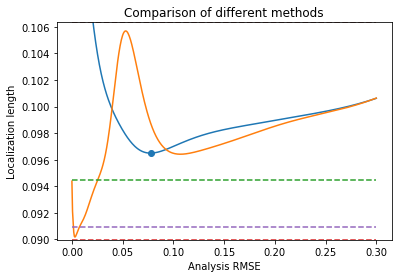

In [23]:
arg_min = np.argmin(rmse_eig)
rmse_eig_min = rmse_eig[arg_min]
opt_eig = loc_array_stdrd[arg_min]
print('Eigenvalue loc RMSE: ', rmse_eig_min)
plt.figure()
plt.plot(loc_array_stdrd, rmse_stdrd)
plt.plot(loc_array_stdrd, rmse_eig)
plt.plot(loc_array_stdrd,
         np.ones_like(loc_array_stdrd) * rmse_Qzl, '--')
plt.plot(loc_array_stdrd,
         np.ones_like(loc_array_stdrd) * rmse_Pz, '--')
plt.plot(loc_array_stdrd,
         np.ones_like(loc_array_stdrd) * rmse_Qz, '--')
plt.plot(loc_array_stdrd,
         np.ones_like(loc_array_stdrd) * rmse_sam, '--')
plt.scatter(opt_stdrd, rmse_stdrd_min)
plt.xlabel('Analysis RMSE')
plt.ylabel('Localization length')
plt.legend(['Standard loc',
            'Eigenvalue loc',
            'First Qz known',
            'Pz known',
            'Qz known',
            'no loc'])
plt.title('Comparison of different methods')

plt.figure()
plt.plot(loc_array_stdrd, rmse_stdrd)
plt.plot(loc_array_stdrd, rmse_eig)
plt.plot(loc_array_stdrd,
         np.ones_like(loc_array_stdrd) * rmse_Qzl, '--')
plt.plot(loc_array_stdrd,
         np.ones_like(loc_array_stdrd) * rmse_Pz, '--')
plt.plot(loc_array_stdrd,
         np.ones_like(loc_array_stdrd) * rmse_Qz, '--')
plt.plot(loc_array_stdrd,
         np.ones_like(loc_array_stdrd) * rmse_sam, '--')
plt.scatter(opt_stdrd, rmse_stdrd_min)
plt.xlabel('Analysis RMSE')
plt.ylabel('Localization length')
# plt.legend(['Standard loc',
#             'Eigenvalue loc',
#             'First Qz known',
#             'Pz known',
#             'Qz known',
#             'no loc'])
plt.title('Comparison of different methods')
ymin = np.min([rmse_Pz, rmse_Qz])
ymax = rmse_sam
plt.ylim([ymin, ymax])
# plt.xlim([0, 0.05])

# Perfect eig localization (tuned seconday loc; projection)

$\mathbf{P}^{roj} = \mathbf{I} - \mathbf{Q}_l \mathbf{Q}_l^T$

$\mathbf{P}_s = \mathbf{L} \circ (\mathbf{P}^{roj} \mathbf{P}_{z; sam} \mathbf{P}^{roj})$

$\mathbf{P} = \mathbf{P}_l + \mathbf{P}_s$

In [24]:
def assimilate_eig_proj(Zens, Zobs,
                        Hz, R, Pz_Qzl,
                        Pz_orth, rho0_loc_s, Proj):
    [L_s] = covariance.generate_circulant(
        Nz, dz, rho0_loc_s,
        covariance.fft_sqd_exp_1d,
        return_eig=False, return_Corr=True)
    Pz_loc = Pz_Qzl + Proj @ (L_s * Pz_orth) @ Proj
    Za = KF(Zens, Zobs, Pz_loc, Hz, R)
    return Za

In [25]:
Proj = np.eye(Nz) - Qzl @ Qzl.T
Pz_orth_proj = Proj @ Pz_sam @ Proj
rmse_eig_proj = rmse_stdrd * np.nan
for count, a_rho0 in enumerate(loc_array_stdrd):
    aZa = assimilate_eig_proj(Zens, Zobs, Hz, R, Pz_Qzl, Pz_orth_proj, a_rho0, Proj)
    a_mu_z = np.mean(aZa, axis=1)
    rmse_eig_proj[count] = np.sqrt(((a_mu_z - mu_z)**2).mean())

Eigenvalue loc RMSE:  0.09017216927953199


(0.0899665313972814, 0.10634214832652958)

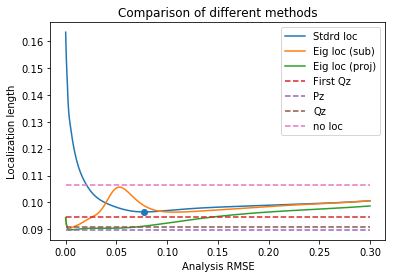

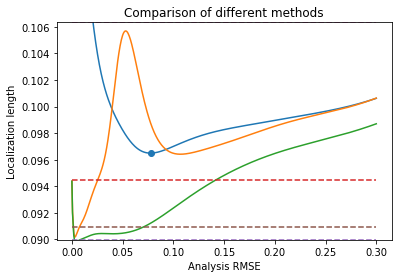

In [26]:
arg_min = np.argmin(rmse_eig)
rmse_eig_min = rmse_eig[arg_min]
opt_eig = loc_array_stdrd[arg_min]
print('Eigenvalue loc RMSE: ', rmse_eig_min)

plt.figure()
plt.plot(loc_array_stdrd, rmse_stdrd)
plt.plot(loc_array_stdrd, rmse_eig)
plt.plot(loc_array_stdrd, rmse_eig_proj)
plt.plot(loc_array_stdrd,
         np.ones_like(loc_array_stdrd) * rmse_Qzl, '--')
plt.plot(loc_array_stdrd,
         np.ones_like(loc_array_stdrd) * rmse_Pz, '--')
plt.plot(loc_array_stdrd,
         np.ones_like(loc_array_stdrd) * rmse_Qz, '--')
plt.plot(loc_array_stdrd,
         np.ones_like(loc_array_stdrd) * rmse_sam, '--')
plt.scatter(opt_stdrd, rmse_stdrd_min)
plt.xlabel('Analysis RMSE')
plt.ylabel('Localization length')
plt.legend(['Stdrd loc',
            'Eig loc (sub)',
            'Eig loc (proj)',
            'First Qz',
            'Pz',
            'Qz',
            'no loc'])
plt.title('Comparison of different methods')

plt.figure()
plt.plot(loc_array_stdrd, rmse_stdrd)
plt.plot(loc_array_stdrd, rmse_eig)
plt.plot(loc_array_stdrd, rmse_eig_proj)
plt.plot(loc_array_stdrd,
         np.ones_like(loc_array_stdrd) * rmse_Qzl, '--')
plt.plot(loc_array_stdrd,
         np.ones_like(loc_array_stdrd) * rmse_Pz, '--')
plt.plot(loc_array_stdrd,
         np.ones_like(loc_array_stdrd) * rmse_Qz, '--')
plt.plot(loc_array_stdrd,
         np.ones_like(loc_array_stdrd) * rmse_sam, '--')
plt.scatter(opt_stdrd, rmse_stdrd_min)
plt.xlabel('Analysis RMSE')
plt.ylabel('Localization length')
# plt.legend(['Stdrd loc',
#             'Eig loc (sub)',
#             'Eig loc (proj)',
#             'First Qz',
#             'Pz',
#             'Qz',
#             'no loc'])
plt.title('Comparison of different methods')
ymin = np.min([rmse_Pz, rmse_Qz])
ymax = rmse_sam
plt.ylim([ymin, ymax])
# plt.xlim([0, 0.05])

# Using coarse ensemble

$\mathbf{Q}_{sam} \mathbf{\Lambda}_{sam} \mathbf{Q}_{sam}^T = \mathbf{P}_{x; sam}$

$\mathbf{Q}_{ls} = interp(\mathbf{Q}_{sam}[:, :N_l])$

$\mathbf{P}^{roj}_s = \mathbf{I} - \mathbf{Q}_{ls} \mathbf{Q}_{ls}^T$

$\mathbf{P}_s = \mathbf{L} \circ (\mathbf{P}^{roj}_s \mathbf{P}_{sam} \mathbf{P}^{roj}_s)$

$\mathbf{P} = \mathbf{P}_l + \mathbf{P}_s$

In [27]:
Nex = 500
mu_x = mu_z[::coarse]
Xens = assimilate.generate_ensemble(Nex, mu_x, P_sqrtx)

Px_sam = np.cov(Xens)
Lam_xsam, Qxsam = np.linalg.eigh(Px_sam)
Lam_xsam = Lam_xsam[::-1]
Qxsam = Qxsam[:, ::-1]

/Users/harty/miniconda3/envs/loc/lib/python3.7/site-packages/matplotlib/pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


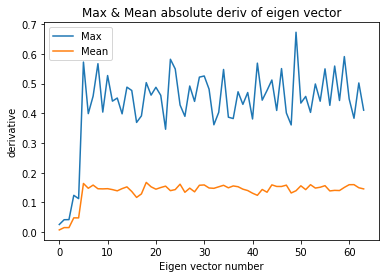

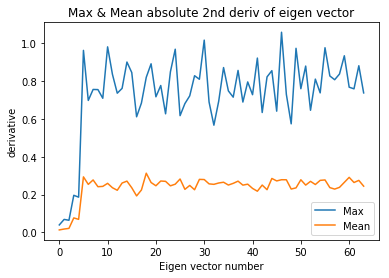

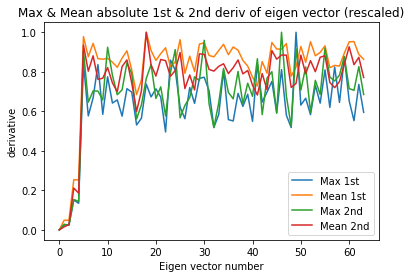

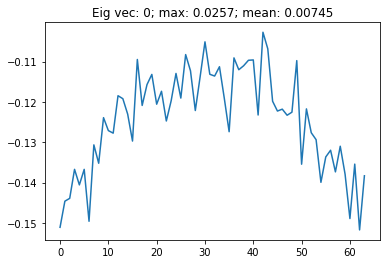

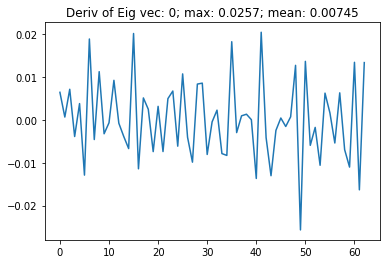

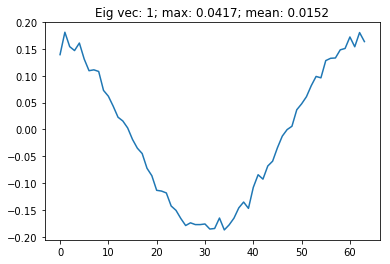

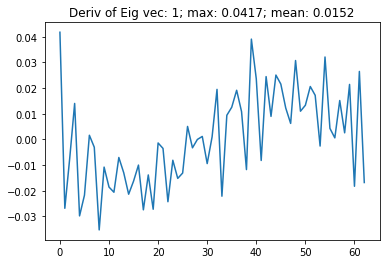

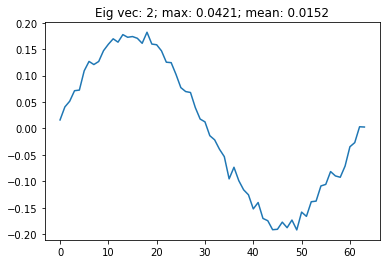

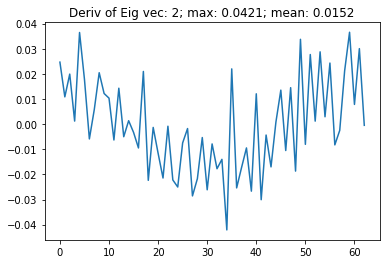

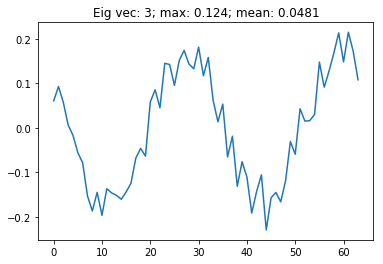

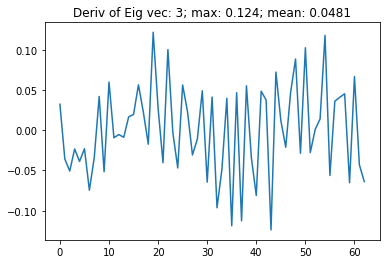

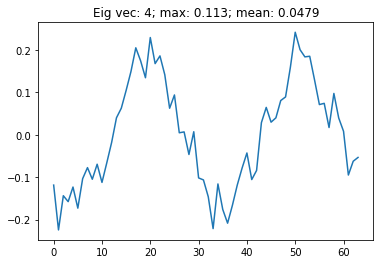

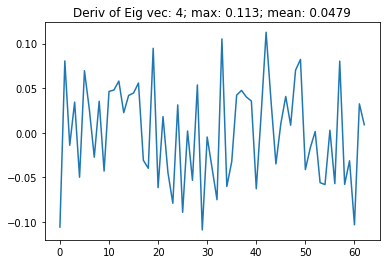

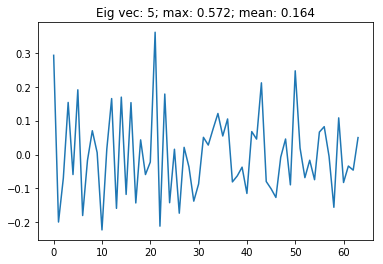

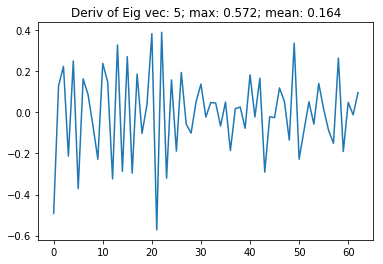

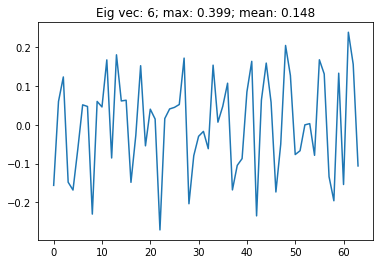

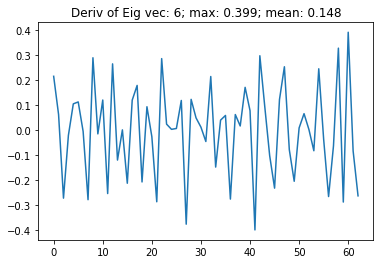

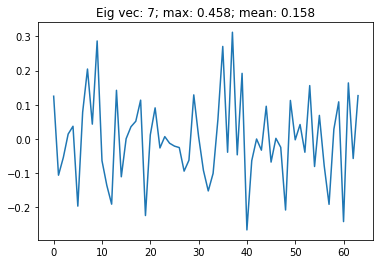

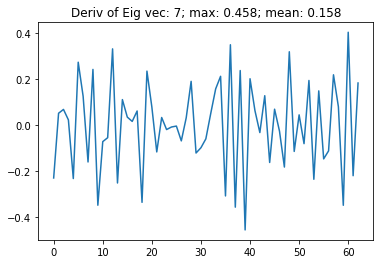

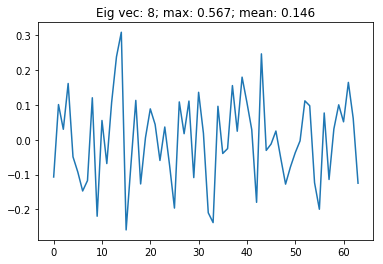

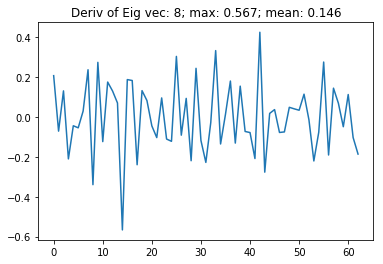

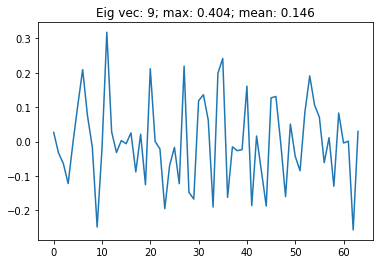

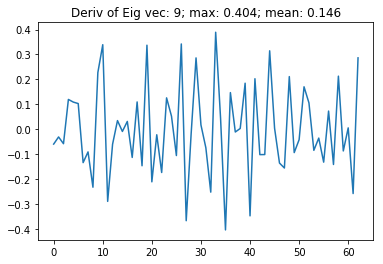

In [28]:
dQxdt = np.diff(Qxsam, axis=0)
d2Qxdt2 = np.diff(dQxdt, axis=0)

max_deriv = np.max(np.abs(dQxdt), axis=0)
mean_deriv = np.mean(np.abs(dQxdt), axis=0)
max_deriv2 = np.max(np.abs(d2Qxdt2), axis=0)
mean_deriv2 = np.mean(np.abs(d2Qxdt2), axis=0)
maxd_norm = (max_deriv - max_deriv.min())/(max_deriv.max() - max_deriv.min())
meand_norm = (mean_deriv - mean_deriv.min())/(mean_deriv.max() - mean_deriv.min())
maxd2_norm = (max_deriv2 - max_deriv2.min())/(max_deriv2.max() - max_deriv2.min())
meand2_norm = (mean_deriv2 - mean_deriv2.min())/(mean_deriv2.max() - mean_deriv2.min())

plt.figure()
plt.plot(max_deriv)
plt.plot(mean_deriv)
plt.title('Max & Mean absolute deriv of eigen vector')
plt.xlabel('Eigen vector number')
plt.ylabel('derivative')
plt.legend(['Max', 'Mean'])

plt.figure()
plt.plot(max_deriv2)
plt.plot(mean_deriv2)
plt.title('Max & Mean absolute 2nd deriv of eigen vector')
plt.xlabel('Eigen vector number')
plt.ylabel('derivative')
plt.legend(['Max', 'Mean'])

plt.figure()
plt.plot(maxd_norm)
plt.plot(meand_norm)
plt.plot(maxd2_norm)
plt.plot(meand2_norm)
plt.title('Max & Mean absolute 1st & 2nd deriv of eigen vector (rescaled)')
plt.xlabel('Eigen vector number')
plt.ylabel('derivative')
plt.legend(['Max 1st', 'Mean 1st',
            'Max 2nd', 'Mean 2nd'])

for ii in range(10):
    plt.figure()
    plt.plot(Qxsam[:, ii])
    plt.title(f'Eig vec: {ii}; max: {max_deriv[ii]:0.3}; mean: {mean_deriv[ii]:0.3}')
    
    plt.figure()
    plt.plot(dQxdt[:, ii])
    plt.title(f'Deriv of Eig vec: {ii}; max: {max_deriv[ii]:0.3}; mean: {mean_deriv[ii]:0.3}')

In [29]:
N_laml = 5
Qzl_sam = Qxsam[:, :N_laml]
Qzl_sam = utilities.upscale_on_loop(Qzl_sam.T, coarse)
Qzl_sam = Qzl_sam.T
Qzl_sam, temp = np.linalg.qr(Qzl_sam)

Proj_sam = np.eye(Nz) - Qzl_sam @ Qzl_sam.T

Lam_zl_sam = np.diag(Qzl_sam.T @ Pz_sam @ Qzl_sam)
Pz_Qsam = Qzl_sam @ np.diag(Lam_zl_sam) @ Qzl_sam.T

Pz_orth_sam = Proj_sam @ Pz_sam @ Proj_sam

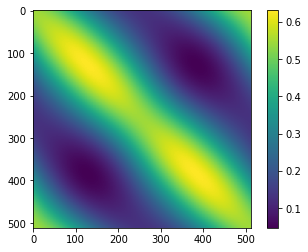

In [30]:
imshow(Pz_Qzl)

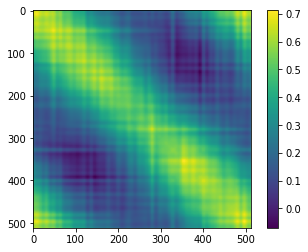

In [31]:
imshow(Pz_Qsam)

In [32]:
rmse_eig_sam = rmse_stdrd * np.nan
for count, a_rho0 in enumerate(loc_array_stdrd):
    aZa = assimilate_eig_proj(Zens, Zobs, Hz, R, Pz_Qsam, Pz_orth_sam, a_rho0, Proj)
    a_mu_z = np.mean(aZa, axis=1)
    rmse_eig_sam[count] = np.sqrt(((a_mu_z - mu_z)**2).mean())

Eigenvalue loc RMSE:  0.09017216927953199


(0.0899665313972814, 0.10634214832652958)

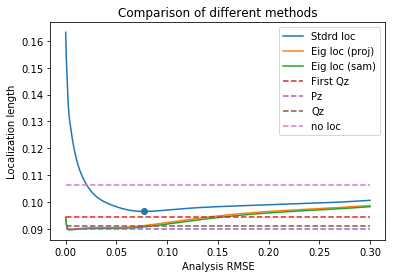

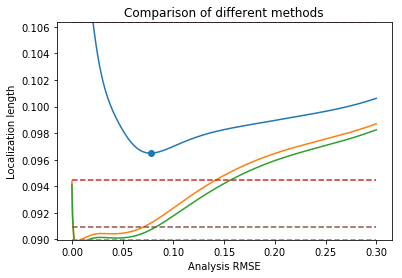

In [33]:
arg_min = np.argmin(rmse_eig)
rmse_eig_min = rmse_eig[arg_min]
opt_eig = loc_array_stdrd[arg_min]
print('Eigenvalue loc RMSE: ', rmse_eig_min)

plt.figure()
plt.plot(loc_array_stdrd, rmse_stdrd)
plt.plot(loc_array_stdrd, rmse_eig_proj)
plt.plot(loc_array_stdrd, rmse_eig_sam)
plt.plot(loc_array_stdrd,
         np.ones_like(loc_array_stdrd) * rmse_Qzl, '--')
plt.plot(loc_array_stdrd,
         np.ones_like(loc_array_stdrd) * rmse_Pz, '--')
plt.plot(loc_array_stdrd,
         np.ones_like(loc_array_stdrd) * rmse_Qz, '--')
plt.plot(loc_array_stdrd,
         np.ones_like(loc_array_stdrd) * rmse_sam, '--')
plt.scatter(opt_stdrd, rmse_stdrd_min)
plt.xlabel('Analysis RMSE')
plt.ylabel('Localization length')
plt.legend(['Stdrd loc',
            'Eig loc (proj)',
            'Eig loc (sam)',
            'First Qz',
            'Pz',
            'Qz',
            'no loc'])
plt.title('Comparison of different methods')

plt.figure()
plt.plot(loc_array_stdrd, rmse_stdrd)
plt.plot(loc_array_stdrd, rmse_eig_proj)
plt.plot(loc_array_stdrd, rmse_eig_sam)
plt.plot(loc_array_stdrd,
         np.ones_like(loc_array_stdrd) * rmse_Qzl, '--')
plt.plot(loc_array_stdrd,
         np.ones_like(loc_array_stdrd) * rmse_Pz, '--')
plt.plot(loc_array_stdrd,
         np.ones_like(loc_array_stdrd) * rmse_Qz, '--')
plt.plot(loc_array_stdrd,
         np.ones_like(loc_array_stdrd) * rmse_sam, '--')
plt.scatter(opt_stdrd, rmse_stdrd_min)
plt.xlabel('Analysis RMSE')
plt.ylabel('Localization length')
# plt.legend(['Stdrd loc',
#             'Eig loc (proj)',
#             'Eig loc (sam)',
#             'First Qz',
#             'Pz',
#             'Qz',
#             'no loc'])
plt.title('Comparison of different methods')
ymin = np.min([rmse_Pz, rmse_Qz])
ymax = rmse_sam
plt.ylim([ymin, ymax])
# plt.xlim([0, 0.05])

# Using coarse ensemble with smoothing

$\mathbf{X}_{smo} = smooth(\mathbf{X})$

$\mathbf{P}_{x; smo} = cov( \mathbf{X}_{smo}$)

$\mathbf{Q}_{sam} \mathbf{\Lambda}_{sam} \mathbf{Q}_{sam}^T = \mathbf{P}_{x; smo}$

In [34]:
Nex = 50
mu_x = mu_z[::coarse]
Xens = assimilate.generate_ensemble(Nex, mu_x, P_sqrtx)
# Xens = ndimage.gaussian_filter1d(Xens, 1, axis=0, mode='wrap')

Px_sam = np.cov(Xens)
Lam_xsam, Qxsam = np.linalg.eigh(Px_sam)
Lam_xsam = Lam_xsam[::-1]
Qxsam = Qxsam[:, ::-1]

In [35]:
N_laml = 5
Qzl_sam = Qxsam[:, :N_laml]
Qzl_sam = utilities.upscale_on_loop(Qzl_sam.T, coarse)
Qzl_sam = Qzl_sam.T
Qzl_sam, temp = np.linalg.qr(Qzl_sam)

Proj_sam = np.eye(Nz) - Qzl_sam @ Qzl_sam.T

Lam_zl_sam = np.diag(Qzl_sam.T @ Pz_sam @ Qzl_sam)
Pz_Qsam = Qzl_sam @ np.diag(Lam_zl_sam) @ Qzl_sam.T

Pz_orth_sam = Proj_sam @ Pz_sam @ Proj_sam

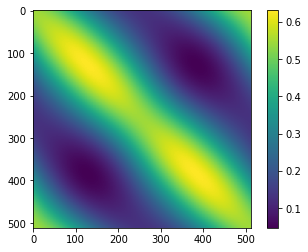

In [36]:
imshow(Pz_Qzl)

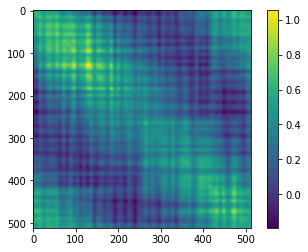

In [37]:
imshow(Pz_Qsam)

In [38]:
rmse_eig_sam = rmse_stdrd * np.nan
for count, a_rho0 in enumerate(loc_array_stdrd):
    aZa = assimilate_eig_proj(Zens, Zobs, Hz, R, Pz_Qsam, Pz_orth_sam, a_rho0, Proj)
    a_mu_z = np.mean(aZa, axis=1)
    rmse_eig_sam[count] = np.sqrt(((a_mu_z - mu_z)**2).mean())

In [39]:
Xens = ndimage.gaussian_filter1d(Xens, 2, axis=0, mode='wrap')

Px_sam = np.cov(Xens)
Lam_xsam, Qxsam = np.linalg.eigh(Px_sam)
Lam_xsam = Lam_xsam[::-1]
Qxsam = Qxsam[:, ::-1]

In [40]:
N_laml = 5
Qzl_sam = Qxsam[:, :N_laml]
Qzl_sam = utilities.upscale_on_loop(Qzl_sam.T, coarse)
Qzl_sam = Qzl_sam.T
Qzl_sam, temp = np.linalg.qr(Qzl_sam)

Proj_sam = np.eye(Nz) - Qzl_sam @ Qzl_sam.T

Lam_zl_sam = np.diag(Qzl_sam.T @ Pz_sam @ Qzl_sam)
Pz_Qsam = Qzl_sam @ np.diag(Lam_zl_sam) @ Qzl_sam.T

Pz_orth_sam = Proj_sam @ Pz_sam @ Proj_sam

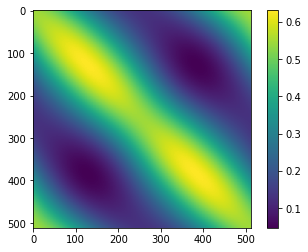

In [41]:
imshow(Pz_Qzl)

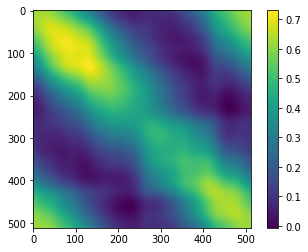

In [42]:
imshow(Pz_Qsam)

In [43]:
rmse_eig_sam_smooth = rmse_stdrd * np.nan
for count, a_rho0 in enumerate(loc_array_stdrd):
    aZa = assimilate_eig_proj(Zens, Zobs, Hz, R, Pz_Qsam, Pz_orth_sam, a_rho0, Proj)
    a_mu_z = np.mean(aZa, axis=1)
    rmse_eig_sam_smooth[count] = np.sqrt(((a_mu_z - mu_z)**2).mean())

Eigenvalue loc RMSE:  0.09017216927953199


(0.0899665313972814, 0.10634214832652958)

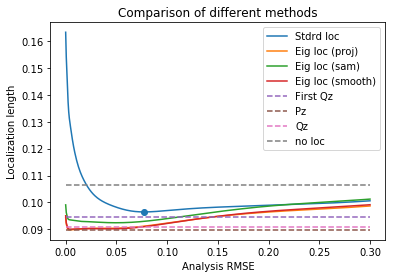

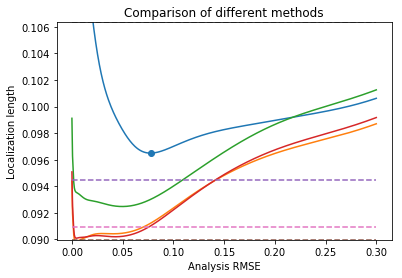

In [44]:
arg_min = np.argmin(rmse_eig)
rmse_eig_min = rmse_eig[arg_min]
opt_eig = loc_array_stdrd[arg_min]
print('Eigenvalue loc RMSE: ', rmse_eig_min)

plt.figure()
plt.plot(loc_array_stdrd, rmse_stdrd)
plt.plot(loc_array_stdrd, rmse_eig_proj)
plt.plot(loc_array_stdrd, rmse_eig_sam)
plt.plot(loc_array_stdrd, rmse_eig_sam_smooth)
plt.plot(loc_array_stdrd,
         np.ones_like(loc_array_stdrd) * rmse_Qzl, '--')
plt.plot(loc_array_stdrd,
         np.ones_like(loc_array_stdrd) * rmse_Pz, '--')
plt.plot(loc_array_stdrd,
         np.ones_like(loc_array_stdrd) * rmse_Qz, '--')
plt.plot(loc_array_stdrd,
         np.ones_like(loc_array_stdrd) * rmse_sam, '--')
plt.scatter(opt_stdrd, rmse_stdrd_min)
plt.xlabel('Analysis RMSE')
plt.ylabel('Localization length')
plt.legend(['Stdrd loc',
            'Eig loc (proj)',
            'Eig loc (sam)',
            'Eig loc (smooth)',
            'First Qz',
            'Pz',
            'Qz',
            'no loc'])
plt.title('Comparison of different methods')

plt.figure()
plt.plot(loc_array_stdrd, rmse_stdrd)
plt.plot(loc_array_stdrd, rmse_eig_proj)
plt.plot(loc_array_stdrd, rmse_eig_sam)
plt.plot(loc_array_stdrd, rmse_eig_sam_smooth)
plt.plot(loc_array_stdrd,
         np.ones_like(loc_array_stdrd) * rmse_Qzl, '--')
plt.plot(loc_array_stdrd,
         np.ones_like(loc_array_stdrd) * rmse_Pz, '--')
plt.plot(loc_array_stdrd,
         np.ones_like(loc_array_stdrd) * rmse_Qz, '--')
plt.plot(loc_array_stdrd,
         np.ones_like(loc_array_stdrd) * rmse_sam, '--')
plt.scatter(opt_stdrd, rmse_stdrd_min)
plt.xlabel('Analysis RMSE')
plt.ylabel('Localization length')
# plt.legend(['Stdrd loc',
#             'Eig loc (proj)',
#             'Eig loc (sam)',
#             'Eig loc (smooth)',
#             'First Qz',
#             'Pz',
#             'Qz',
#             'no loc'])
plt.title('Comparison of different methods')
ymin = np.min([rmse_Pz, rmse_Qz])
ymax = rmse_sam
plt.ylim([ymin, ymax])
# plt.xlim([0, 0.05])

# Using coarse ensemble correlation not covariance

Not correct.

$\mathbf{Q}_{sam} \mathbf{\Lambda}_{sam} \mathbf{Q}_{sam}^T = \mathbf{P}_{x; sam}$

$\mathbf{Q}_{ls} = interp(\mathbf{Q}_{sam}[:, :N_l])$

$\mathbf{P}^{roj}_s = \mathbf{I} - \mathbf{Q}_{ls} \mathbf{Q}_{ls}^T$

$\mathbf{P}_s = \mathbf{L} \circ (\mathbf{P}^{roj}_s \mathbf{P}_{sam} \mathbf{P}^{roj}_s)$

$\mathbf{P} = \mathbf{P}_l + \mathbf{P}_s$

In [45]:
Nex = 500
mu_x = mu_z[::coarse]
Xens = assimilate.generate_ensemble(Nex, mu_x, P_sqrtx)

Cx_sam = np.corrcoef(Xens)
# Px_sam = np.cov(Xens)
Lam_xsam, Qxsam = np.linalg.eigh(Px_sam)
Lam_xsam = Lam_xsam[::-1]
Qxsam = Qxsam[:, ::-1]

Cz_sam = np.corrcoef(Zens)

std_z = np.std(Zens, axis=1)

In [46]:
N_laml = 5
Qzl_sam = Qxsam[:, :N_laml]
Qzl_sam = utilities.upscale_on_loop(Qzl_sam.T, coarse)
Qzl_sam = Qzl_sam.T
Qzl_sam, temp = np.linalg.qr(Qzl_sam)

Proj_sam = np.eye(Nz) - Qzl_sam @ Qzl_sam.T

Lam_zl_sam = np.diag(Qzl_sam.T @ Cz_sam @ Qzl_sam)
Cz_Qsam = Qzl_sam @ np.diag(Lam_zl_sam) @ Qzl_sam.T

Cz_orth_sam = Proj_sam @ Cz_sam @ Proj_sam

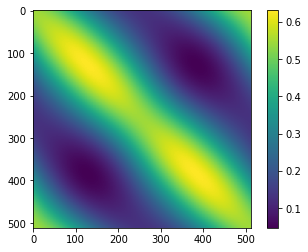

In [47]:
imshow(Pz_Qzl)

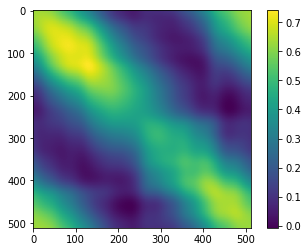

In [48]:
imshow(Cz_Qsam)

In [49]:
def assimilate_eig_proj_C(Zens, Zobs,
                        Hz, R, Cz_Qzl,
                        Cz_orth, rho0_loc_s, Proj, std_z):
    [L_s] = covariance.generate_circulant(
        Nz, dz, rho0_loc_s,
        covariance.fft_sqd_exp_1d,
        return_eig=False, return_Corr=True)
    Cz_loc = Cz_Qzl + Proj @ (L_s * Cz_orth) @ Proj
    Dz = np.diag(1/np.sqrt(np.diag(Cz_loc)))
    Cz_loc = Dz @ Cz_loc @ Dz
    Pz_loc = np.diag(std_z) @ Cz_loc @ np.diag(std_z)
    
    Za = KF(Zens, Zobs, Pz_loc, Hz, R)
    return Za

In [50]:
rmse_eig_sam = rmse_stdrd * np.nan
for count, a_rho0 in enumerate(loc_array_stdrd):
    aZa = assimilate_eig_proj_C(Zens, Zobs, Hz, R, Cz_Qsam, Cz_orth_sam, a_rho0, Proj, std_z)
    a_mu_z = np.mean(aZa, axis=1)
    rmse_eig_sam[count] = np.sqrt(((a_mu_z - mu_z)**2).mean())

Eigenvalue loc RMSE:  0.09017216927953199


(0.0899665313972814, 0.10634214832652958)

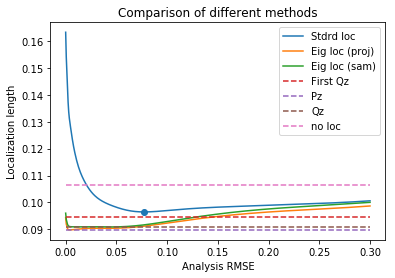

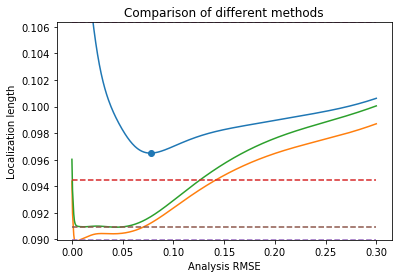

In [51]:
arg_min = np.argmin(rmse_eig)
rmse_eig_min = rmse_eig[arg_min]
opt_eig = loc_array_stdrd[arg_min]
print('Eigenvalue loc RMSE: ', rmse_eig_min)

plt.figure()
plt.plot(loc_array_stdrd, rmse_stdrd)
plt.plot(loc_array_stdrd, rmse_eig_proj)
plt.plot(loc_array_stdrd, rmse_eig_sam)
plt.plot(loc_array_stdrd,
         np.ones_like(loc_array_stdrd) * rmse_Qzl, '--')
plt.plot(loc_array_stdrd,
         np.ones_like(loc_array_stdrd) * rmse_Pz, '--')
plt.plot(loc_array_stdrd,
         np.ones_like(loc_array_stdrd) * rmse_Qz, '--')
plt.plot(loc_array_stdrd,
         np.ones_like(loc_array_stdrd) * rmse_sam, '--')
plt.scatter(opt_stdrd, rmse_stdrd_min)
plt.xlabel('Analysis RMSE')
plt.ylabel('Localization length')
plt.legend(['Stdrd loc',
            'Eig loc (proj)',
            'Eig loc (sam)',
            'First Qz',
            'Pz',
            'Qz',
            'no loc'])
plt.title('Comparison of different methods')

plt.figure()
plt.plot(loc_array_stdrd, rmse_stdrd)
plt.plot(loc_array_stdrd, rmse_eig_proj)
plt.plot(loc_array_stdrd, rmse_eig_sam)
plt.plot(loc_array_stdrd,
         np.ones_like(loc_array_stdrd) * rmse_Qzl, '--')
plt.plot(loc_array_stdrd,
         np.ones_like(loc_array_stdrd) * rmse_Pz, '--')
plt.plot(loc_array_stdrd,
         np.ones_like(loc_array_stdrd) * rmse_Qz, '--')
plt.plot(loc_array_stdrd,
         np.ones_like(loc_array_stdrd) * rmse_sam, '--')
plt.scatter(opt_stdrd, rmse_stdrd_min)
plt.xlabel('Analysis RMSE')
plt.ylabel('Localization length')
# plt.legend(['Stdrd loc',
#             'Eig loc (proj)',
#             'Eig loc (sam)',
#             'First Qz',
#             'Pz',
#             'Qz',
#             'no loc'])
plt.title('Comparison of different methods')
ymin = np.min([rmse_Pz, rmse_Qz])
ymax = rmse_sam
plt.ylim([ymin, ymax])
# plt.xlim([0, 0.05])